# Red Neuronal Profunda (DNN) para clasificación MNIST

Aplicaremos todos nuestros conocimientos para crear una DNN, frecuentemente llamada también una Artificial Neural Network (ANN).  El problema que vamos a trabajar se conoce como el "Hola Mundo" del aprendizaje profundo porque para la mayoría de estudiantes este es el primer algoritmo de aprendizaje profundo que ven. 

El conjunto de datos se llama MNIST y se refiere al reconocimiento de dígitos escritos a mano.  Pueden encontrar más información en el sitio web de Yann LeCun (Director of AI Research, Facebook).  El es uno de los pioneros de todo este tema, así como de otras metodologías más complejas como las Redes Neurales Convolucionales (CNN) que se utilizan hoy día.

El conjunto de datos tiene 70,000 imágenes (28x28 pixels) de dígitos escritos a mano (1 dígito por imagen).

La meta es escribir un algoritmo que detecta qué dígito ha sido escrito.  Como solo hay 10 dígitos (0 al 9), este es un problema de clasificación con 10 clases.

Nuestra meta será construir una RN con 2 capas escondidas.

## Plan de Acción para preparar el modelo

1.  Preparar los datos y preprocesarlos.  Crear los conjuntos de datos para entrenar, validar y probar
2.  Crear un esboso del modelo y seleccionar las funciones de activación
3.  Fijar los optimizadores avanzados y la función de pérdida
4.  Hacer que el modelo aprenda
5.  Probar la exactitud ("accuracy") del modelo

## Importar los paquetes relevantes

TensorFlow incluye un proveedor de los datos de MNIST que utilizaremos acá.  Viene con el módulo **"tensorflow.keras.datasets"**. 

In [ ]:
import numpy as np
import tensorflow as tf

La siguiente instrucción, cuando se corre por primera vez, descarga el conjunto de datos en lo indicado por el parámetro path, relativo a  ~/.keras/datasets).  Como si se hubiera ejecutado Lo siguiente:

tf.keras.datasets.mnist.load_data(
    path = 'mnist.npz'
)

luego separa los datos en un conjunto para entrenamiento y otro para pruebas.

Si se ejecuta más de una vez, ya no descarga el archivo.

In [ ]:
(X_entreno, y_entreno), (X_prueba, y_prueba) = tf.keras.datasets.mnist.load_data()


In [ ]:
X_entreno

Como no podemos ver la forma de los conjuntos...les queda de tarea averiguar por qué no...podemos utilizar la instrucción **assert**

In [ ]:
assert X_entreno.shape == (60000, 28, 28)
assert X_prueba.shape == (10000, 28, 28)
assert y_entreno.shape == (60000,)
assert y_prueba.shape == (10000,)

## Datos

Esta sección es donde pre-procesaremos nuestros datos.

Por default, TF2 tiene conjuntos de datos de entrenamiento y de prueba, pero no tiene un conjunto de validación, por lo que debemos dividirlo por nuestra cuenta

Lo haremos del mismo tamaño que el conjunto de prueba

In [ ]:
num_obs_validacion = y_prueba.shape[0]

Usaremos una variable dedicada para el número de observaciones de prueba

In [ ]:
num_obs_prueba = y_prueba.shape[0]

Generalmente preferimos "normalizar" nuestros datos en alguna forma para que el resultado sea numéricamente más estable.  En este caso simplemente preferimos tener entradas entre 0 y 1, por lo que definimos una función, que reciba la imagen MNIST.

Como los posibles valores de las entradas son entre 0 y 255 (256 posibles tonos de gris), al dividirlos por 255 obtenemos el resultado deseado.

In [ ]:
X_entreno_normalizado = X_entreno / 255

Finalmente, normalizaremos y convertiremos los datos de pruebas en tandas.  Los normalizamos para que tengan la misma magnitud que los datos de entrenamiento y validación.

No hay necesidad de "barajearlo" ya que no estaremos entrenando con los datos de prueba.  Habra una sola tanda, igual al tamaño de los datos de prueba.

In [ ]:
X_prueba_normalizado = X_prueba / 255

Una vez se han "normalizado" los datos, podemos proceder a extraer los datos de entrenamiento y de validación.

Nuestros datos de validación serán 10000 para ser igual al conjunto de prueba.

Finalmente, creamos una tanda con un tamaño de tanda igual al total de muestras de validación.

In [ ]:
X_validacion = X_entreno_normalizado[-num_obs_validacion: , : , : ]
y_validacion = y_entreno[-num_obs_validacion:]

Similarmente, los datos de entrenamiento son todos los demás por lo que nos salteamos tantas observaciones como las hay en el conjunto de validación.

In [ ]:
X_entreno = X_entreno_normalizado[ : X_entreno_normalizado.shape[0] - num_obs_validacion, : , : ]
y_entreno = y_entreno[ : y_entreno.shape[0] - num_obs_validacion]
num_obs_entreno = y_entreno.shape[0]

Convertir de Arreglos Numpy a Tensores

In [ ]:
datos_entreno = tf.data.Dataset.from_tensor_slices((X_entreno, y_entreno))
datos_validacion = tf.data.Dataset.from_tensor_slices((X_validacion, y_validacion))
datos_prueba = tf.data.Dataset.from_tensor_slices((X_prueba, y_prueba))

Barajear y hacer tandas con el conjunto de datos de entrenamiento

In [ ]:
TAMANO_TANDA = 100
datos_entreno = datos_entreno.shuffle(buffer_size = num_obs_entreno).batch(TAMANO_TANDA)

Hacer tandas con los conjuntos de validación y prueba, no se necesita barajearlos

In [ ]:
datos_validacion = datos_validacion.batch(TAMANO_TANDA)
datos_prueba = datos_prueba.batch(TAMANO_TANDA)

## Modelo

### Delineamos el modelo

Cuando pensamos sobre un algoritmo de aprendizaje profundo, casi siempre imaginamos la realización del mismo.  Asi que esta vez, hagámoslo.  :)

In [ ]:
tamano_entrada = 784
tamano_salida = 10

Usaremos el mismo ancho para ambas capas escondidas.  (No es una necesidad!)

In [ ]:
tamano_capa_escondida = 50

# Definimos cómo se verá el modelo

La primera capa (la de entrada):  cada observación es de 28x28 píxeles, por lo tanto es un tensor de rango 2.

Como aún no hemos aprendido sobre CNNs, no sabemos como alimentar este tipo de entrada a nuestra red, por lo tanto hay que "aplanar" las imágenes.  Hay un método conveniente **Flatten** que toma nuestro tensor de 28x28 y lo convierte en  un vector (None,) o (784,)...porque 28x28 = 784.  Esto nos permite crear una red de alimentación hacia adelante.

    
**tf.keras.layers.Dense** básicamente implementa:  *salida = activation(dot(entrada, peso) + sesgo)*.  Requiere varios argumentos, pero los más importantes para nosotros son el ancho de la capa escondida y la función de activación.

La capa final no es diferente, solo nos aseguramos de activarla con **softmax**


In [ ]:
modelo = tf.keras.Sequential([

    tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
    
    tf.keras.layers.Dense(tamano_capa_escondida, activation='relu'), # 1era capa escondida
    tf.keras.layers.Dense(tamano_capa_escondida, activation='relu'), # 2nda capa escondida

    tf.keras.layers.Dense(tamano_salida, activation='softmax') # capa salida
])

### Seleccionar el optimizador y la función de pérdida

Definimos el optimizador que nos gustaría utilizar, la función de pérdida, y las métricas que nos interesa obtener en cada interacción

In [ ]:
modelo.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Entrenamiento

Acá es donde entrenamos el modelo que hemos construído

Determinamos el número máximo de épocas.

Ajustamos el modelo , especificando:

* los datos de entrenamiento
* el número total de épocas
* y los datos de validación que creamos en el formato (entradas, metas)

In [ ]:
NUMERO_EPOCAS = 5

modelo.fit(datos_entreno,
          epochs = NUMERO_EPOCAS, 
          validation_data = datos_validacion,
          verbose = 2)

## Probar el modelo

Como se discutió en clase, luego del entrenamiento (con los datos de entrenamiento), y la validación (con los datos de validación), probamos el potencial de predicción final de nuestro modelo con el conjunto de datos de prueba que el algoritmo NUNCA ha visto antes.

Es muy importante reconocer que estar "jugando" con los hiperparámetros sobre-ajusta el conjunto de datos de validación.

La prueba es la instancia absolutamente final. **NUNCA** debe probarse el modelo antes de haber completamente ajustado el mismo.

Si se ajusta el modelo después de hacer la prueba, se empezará a sobre-ajustar el conjunto de datos de prueba, que echaría "por los suelos" el propósito original del mismo.

In [ ]:
perdida_prueba, precision_prueba = modelo.evaluate(datos_prueba)

In [ ]:
# Si se desea, se puede aplicar un formateo "bonito"
print('Pérdida de prueba: {0:.2f}. Precisión de prueba: {1:.2f}%'.format(perdida_prueba, precision_prueba * 100.))

Utilizando el modelo inicial y los hiperparámetros dados en este notebook, la precisión de prueba final debe ser aproximadamente 97%.

Cada vez que se ejecuta el código, se obtiene una precisión diferente debido a la "barajeada" de las tandas, los pesos se inicializan en forma diferente, etc.

Finalmente, intencionalmente se ha llegado a una solución subóptima, para que puedan tener la oportunidad de mejorarla como ejercicio de laboratorio.

## Ejercicio 1:
### Modificación del Ancho de la Red


In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime

tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [2]:
(X_entreno, y_entreno), (X_prueba, y_prueba) = tf.keras.datasets.mnist.load_data()

assert X_entreno.shape == (60000, 28, 28)
assert X_prueba.shape == (10000, 28, 28)
assert y_entreno.shape == (60000,)
assert y_prueba.shape == (10000,)

num_obs_validacion = y_prueba.shape[0]  
num_obs_prueba = y_prueba.shape[0]      

X_entreno_normalizado = X_entreno / 255.0
X_prueba_normalizado = X_prueba / 255.0

X_validacion = X_entreno_normalizado[-num_obs_validacion:, :, :]
y_validacion = y_entreno[-num_obs_validacion:]

X_entreno = X_entreno_normalizado[:X_entreno_normalizado.shape[0] - num_obs_validacion, :, :]
y_entreno = y_entreno[:y_entreno.shape[0] - num_obs_validacion]

num_obs_entreno = y_entreno.shape[0]

print(f"Datos de entrenamiento: {X_entreno.shape[0]} muestras")
print(f"Datos de validación: {X_validacion.shape[0]} muestras")
print(f"Datos de prueba: {X_prueba.shape[0]} muestras")

TAMANO_TANDA = 100

datos_entreno = tf.data.Dataset.from_tensor_slices((X_entreno, y_entreno))
datos_entreno = datos_entreno.shuffle(buffer_size=num_obs_entreno).batch(TAMANO_TANDA)

datos_validacion = tf.data.Dataset.from_tensor_slices((X_validacion, y_validacion))
datos_validacion = datos_validacion.batch(TAMANO_TANDA)

datos_prueba = tf.data.Dataset.from_tensor_slices((X_prueba_normalizado, y_prueba))
datos_prueba = datos_prueba.batch(TAMANO_TANDA)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Datos de entrenamiento: 50000 muestras
Datos de validación: 10000 muestras
Datos de prueba: 10000 muestras


In [3]:
def crear_modelo(tamano_capa_escondida, tamano_entrada=784, tamano_salida=10):
    modelo = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(tamano_capa_escondida, activation='relu'),
        tf.keras.layers.Dense(tamano_capa_escondida, activation='relu'),
        tf.keras.layers.Dense(tamano_salida, activation='softmax')
    ])
    
    modelo.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    

    return modelo

def entrenar_modelo(tamano_capa_escondida, epocas=5, verbose=1):
    print(f"\n{'='*60}")
    print(f"Entrenando {tamano_capa_escondida} neuronas por capa")
    print(f"{'='*60}")
    
    modelo = crear_modelo(tamano_capa_escondida)
    
    print(f"\nArquitectura del modelo:")
    modelo.summary()
    
    total_params = modelo.count_params()
    print(f"Total de parámetros: {total_params:,}")
    
    inicio_tiempo = time.time()
    
    historial = modelo.fit(
        datos_entreno,
        epochs=epocas,
        validation_data=datos_validacion,
        verbose=verbose
    )
    
    fin_tiempo = time.time()
    tiempo_entrenamiento = fin_tiempo - inicio_tiempo
    
    perdida_prueba, precision_prueba = modelo.evaluate(datos_prueba, verbose=0)
    
    precision_entreno = historial.history['accuracy'][-1]
    precision_validacion = historial.history['val_accuracy'][-1]
    perdida_entreno = historial.history['loss'][-1]
    perdida_validacion = historial.history['val_loss'][-1]
    
    resultados = {
        'tamaño_capa': tamano_capa_escondida,
        'total_parametros': total_params,
        'tiempo_entrenamiento': tiempo_entrenamiento,
        'precision_entreno': precision_entreno,
        'precision_validacion': precision_validacion,
        'precision_prueba': precision_prueba,
        'perdida_entreno': perdida_entreno,
        'perdida_validacion': perdida_validacion,
        'perdida_prueba': perdida_prueba,
        'historial': historial.history
    }
    
    print(f"\nRESULTADOS:")
    print(f"Tiempo de entrenamiento: {tiempo_entrenamiento:.2f} segundos")
    print(f"Precisión entrenamiento: {precision_entreno:.4f} ({precision_entreno*100:.2f}%)")
    print(f"Precisión validación: {precision_validacion:.4f} ({precision_validacion*100:.2f}%)")
    print(f"Precisión prueba: {precision_prueba:.4f} ({precision_prueba*100:.2f}%)")
    
    return resultados, modelo

In [4]:
tamanos_capa = [50, 100, 200, 300, 500]
NUMERO_EPOCAS = 5

todos_resultados = []

print("INICIANDO EXPERIMENTOS CON DIFERENTES TAMAÑOS DE CAPA")
print(f"Tamaños a probar: {tamanos_capa}")
print(f"Número de épocas: {NUMERO_EPOCAS}")

for tamano in tamanos_capa:
    resultados, modelo = entrenar_modelo(tamano, epocas=NUMERO_EPOCAS, verbose=2)
    todos_resultados.append(resultados)
    
    del modelo
    tf.keras.backend.clear_session()


INICIANDO EXPERIMENTOS CON DIFERENTES TAMAÑOS DE CAPA
Tamaños a probar: [50, 100, 200, 300, 500]
Número de épocas: 5

Entrenando 50 neuronas por capa

Arquitectura del modelo:


/Users/soporte/miniconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        39,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,310 (165.27 KB)

 Trainable params: 42,310 (165.27 KB)

 Non-trainable params: 0 (0.00 B)

Total de parámetros: 42,310
Epoch 1/5
500/500 - 1s - 2ms/step - accuracy: 0.8712 - loss: 0.4576 - val_accuracy: 0.9403 - val_loss: 0.2169
Epoch 2/5
500/500 - 0s - 753us/step - accuracy: 0.9418 - loss: 0.2026 - val_accuracy: 0.9554 - val_loss: 0.1604
Epoch 3/5
500/500 - 0s - 806us/step - accuracy: 0.9556 - loss: 0.1525 - val_accuracy: 0.9604 - val_loss: 0.1429
Epoch 4/5
500/500 - 0s - 782us/step - accuracy: 0.9634 - loss: 0.1236 - val_accuracy: 0.9672 - val_loss: 0.1215
Epoch 5/5
500/500 - 0s - 794us/step - accuracy: 0.9693 - loss: 0.1032 - val_accuracy: 0.9628 - val_loss: 0.1249

RESULTADOS:
Tiempo de entrenamiento: 2.47 segundos
Precisión entrenamiento: 0.9693 (96.93%)
Precisión validación: 0.9628 (96.28%)
Precisión prueba: 0.9598 (95.98%)

Entrenando 100 neuronas por capa

Arquitectura del modelo:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,610 (350.04 KB)

 Trainable params: 89,610 (350.04 KB)

 Non-trainable params: 0 (0.00 B)

Total de parámetros: 89,610
Epoch 1/5
500/500 - 1s - 2ms/step - accuracy: 0.8995 - loss: 0.3520 - val_accuracy: 0.9485 - val_loss: 0.1799
Epoch 2/5
500/500 - 1s - 1ms/step - accuracy: 0.9575 - loss: 0.1452 - val_accuracy: 0.9654 - val_loss: 0.1227
Epoch 3/5
500/500 - 1s - 1ms/step - accuracy: 0.9686 - loss: 0.1048 - val_accuracy: 0.9648 - val_loss: 0.1149
Epoch 4/5
500/500 - 1s - 1ms/step - accuracy: 0.9775 - loss: 0.0777 - val_accuracy: 0.9710 - val_loss: 0.1017
Epoch 5/5
500/500 - 1s - 1ms/step - accuracy: 0.9807 - loss: 0.0624 - val_accuracy: 0.9755 - val_loss: 0.0894

RESULTADOS:
Tiempo de entrenamiento: 3.29 segundos
Precisión entrenamiento: 0.9807 (98.07%)
Precisión validación: 0.9755 (97.55%)
Precisión prueba: 0.9757 (97.57%)

Entrenando 200 neuronas por capa

Arquitectura del modelo:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │       157,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,210 (778.16 KB)

 Trainable params: 199,210 (778.16 KB)

 Non-trainable params: 0 (0.00 B)

Total de parámetros: 199,210
Epoch 1/5
500/500 - 1s - 3ms/step - accuracy: 0.9160 - loss: 0.2901 - val_accuracy: 0.9611 - val_loss: 0.1321
Epoch 2/5
500/500 - 1s - 2ms/step - accuracy: 0.9667 - loss: 0.1101 - val_accuracy: 0.9658 - val_loss: 0.1082
Epoch 3/5
500/500 - 1s - 2ms/step - accuracy: 0.9780 - loss: 0.0721 - val_accuracy: 0.9746 - val_loss: 0.0825
Epoch 4/5
500/500 - 1s - 2ms/step - accuracy: 0.9829 - loss: 0.0532 - val_accuracy: 0.9748 - val_loss: 0.0810
Epoch 5/5
500/500 - 1s - 2ms/step - accuracy: 0.9871 - loss: 0.0393 - val_accuracy: 0.9754 - val_loss: 0.0797

RESULTADOS:
Tiempo de entrenamiento: 4.99 segundos
Precisión entrenamiento: 0.9871 (98.71%)
Precisión validación: 0.9754 (97.54%)
Precisión prueba: 0.9769 (97.69%)

Entrenando 300 neuronas por capa

Arquitectura del modelo:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         3,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,810 (1.25 MB)

 Trainable params: 328,810 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

Total de parámetros: 328,810
Epoch 1/5
500/500 - 2s - 3ms/step - accuracy: 0.9260 - loss: 0.2513 - val_accuracy: 0.9593 - val_loss: 0.1368
Epoch 2/5
500/500 - 1s - 2ms/step - accuracy: 0.9704 - loss: 0.0942 - val_accuracy: 0.9721 - val_loss: 0.0938
Epoch 3/5
500/500 - 1s - 2ms/step - accuracy: 0.9813 - loss: 0.0598 - val_accuracy: 0.9719 - val_loss: 0.1012
Epoch 4/5
500/500 - 1s - 2ms/step - accuracy: 0.9856 - loss: 0.0444 - val_accuracy: 0.9788 - val_loss: 0.0775
Epoch 5/5
500/500 - 1s - 2ms/step - accuracy: 0.9903 - loss: 0.0306 - val_accuracy: 0.9750 - val_loss: 0.0985

RESULTADOS:
Tiempo de entrenamiento: 6.42 segundos
Precisión entrenamiento: 0.9903 (99.03%)
Precisión validación: 0.9750 (97.50%)
Precisión prueba: 0.9751 (97.51%)

Entrenando 500 neuronas por capa

Arquitectura del modelo:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │       392,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 500)            │       250,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         5,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,010 (2.47 MB)

 Trainable params: 648,010 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

Total de parámetros: 648,010
Epoch 1/5
500/500 - 2s - 4ms/step - accuracy: 0.9315 - loss: 0.2275 - val_accuracy: 0.9651 - val_loss: 0.1191
Epoch 2/5
500/500 - 2s - 4ms/step - accuracy: 0.9739 - loss: 0.0844 - val_accuracy: 0.9713 - val_loss: 0.1013
Epoch 3/5
500/500 - 2s - 4ms/step - accuracy: 0.9826 - loss: 0.0546 - val_accuracy: 0.9764 - val_loss: 0.0799
Epoch 4/5
500/500 - 2s - 4ms/step - accuracy: 0.9888 - loss: 0.0371 - val_accuracy: 0.9779 - val_loss: 0.0834
Epoch 5/5
500/500 - 2s - 4ms/step - accuracy: 0.9902 - loss: 0.0297 - val_accuracy: 0.9781 - val_loss: 0.0857

RESULTADOS:
Tiempo de entrenamiento: 10.01 segundos
Precisión entrenamiento: 0.9902 (99.02%)
Precisión validación: 0.9781 (97.81%)
Precisión prueba: 0.9789 (97.89%)



TABLA COMPARATIVA DE RESULTADOS
 Tamaño Capa  Parámetros  Tiempo (s)  Precisión Entreno (%)  Precisión Validación (%)  Precisión Prueba (%)
          50       42310        2.47                  96.93                     96.28                 95.98
         100       89610        3.29                  98.07                     97.55                 97.57
         200      199210        4.99                  98.71                     97.54                 97.69
         300      328810        6.42                  99.03                     97.50                 97.51
         500      648010       10.01                  99.02                     97.81                 97.89

ANÁLISIS DE MEJORES MODELOS:
Mejor precisión en validación: 500 neuronas (97.81%)
Mejor precisión en prueba: 500 neuronas (97.89%)


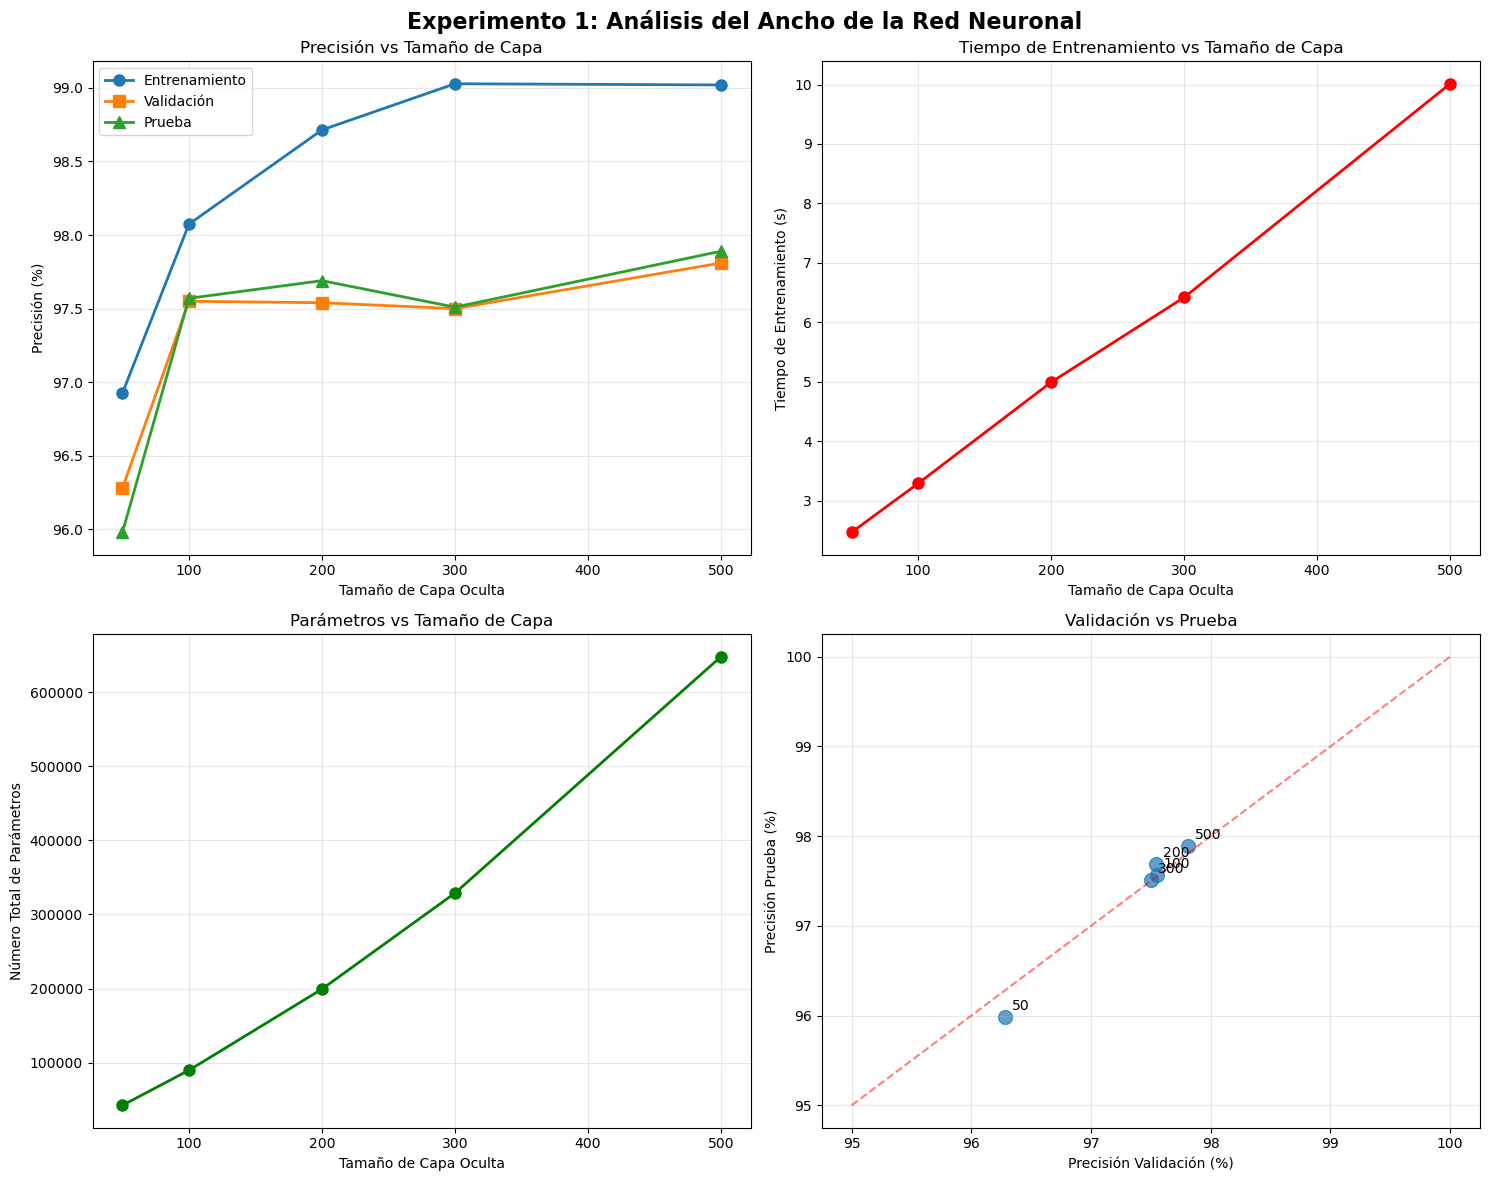

In [8]:
df_resultados = pd.DataFrame(todos_resultados)

print(f"\n{'='*80}")
print("TABLA COMPARATIVA DE RESULTADOS")
print(f"{'='*80}")

tabla_display = df_resultados[['tamaño_capa', 'total_parametros', 'tiempo_entrenamiento', 
                              'precision_entreno', 'precision_validacion', 'precision_prueba']].copy()

tabla_display['tiempo_entrenamiento'] = tabla_display['tiempo_entrenamiento'].round(2)
tabla_display['precision_entreno'] = (tabla_display['precision_entreno'] * 100).round(2)
tabla_display['precision_validacion'] = (tabla_display['precision_validacion'] * 100).round(2)
tabla_display['precision_prueba'] = (tabla_display['precision_prueba'] * 100).round(2)

tabla_display.columns = ['Tamaño Capa', 'Parámetros', 'Tiempo (s)', 
                        'Precisión Entreno (%)', 'Precisión Validación (%)', 'Precisión Prueba (%)']

print(tabla_display.to_string(index=False))

mejor_validacion = df_resultados.loc[df_resultados['precision_validacion'].idxmax()]
mejor_prueba = df_resultados.loc[df_resultados['precision_prueba'].idxmax()]

print(f"\n{'='*60}")
print("ANÁLISIS DE MEJORES MODELOS:")
print(f"{'='*60}")
print(f"Mejor precisión en validación: {mejor_validacion['tamaño_capa']} neuronas "
      f"({mejor_validacion['precision_validacion']*100:.2f}%)")
print(f"Mejor precisión en prueba: {mejor_prueba['tamaño_capa']} neuronas "
      f"({mejor_prueba['precision_prueba']*100:.2f}%)")

plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Experimento 1: Análisis del Ancho de la Red Neuronal', fontsize=16, fontweight='bold')

axes[0, 0].plot(df_resultados['tamaño_capa'], df_resultados['precision_entreno'] * 100, 
               'o-', label='Entrenamiento', linewidth=2, markersize=8)
axes[0, 0].plot(df_resultados['tamaño_capa'], df_resultados['precision_validacion'] * 100, 
               's-', label='Validación', linewidth=2, markersize=8)
axes[0, 0].plot(df_resultados['tamaño_capa'], df_resultados['precision_prueba'] * 100, 
               '^-', label='Prueba', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Tamaño de Capa Oculta')
axes[0, 0].set_ylabel('Precisión (%)')
axes[0, 0].set_title('Precisión vs Tamaño de Capa')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(df_resultados['tamaño_capa'], df_resultados['tiempo_entrenamiento'], 
               'ro-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Tamaño de Capa Oculta')
axes[0, 1].set_ylabel('Tiempo de Entrenamiento (s)')
axes[0, 1].set_title('Tiempo de Entrenamiento vs Tamaño de Capa')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(df_resultados['tamaño_capa'], df_resultados['total_parametros'], 
               'go-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Tamaño de Capa Oculta')
axes[1, 0].set_ylabel('Número Total de Parámetros')
axes[1, 0].set_title('Parámetros vs Tamaño de Capa')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(df_resultados['precision_validacion'] * 100, 
                  df_resultados['precision_prueba'] * 100, 
                  s=100, alpha=0.7)
for i, txt in enumerate(df_resultados['tamaño_capa']):
    axes[1, 1].annotate(f'{txt}', 
                       (df_resultados['precision_validacion'].iloc[i] * 100, 
                        df_resultados['precision_prueba'].iloc[i] * 100),
                       xytext=(5, 5), textcoords='offset points')
axes[1, 1].plot([95, 100], [95, 100], 'r--', alpha=0.5)  
axes[1, 1].set_xlabel('Precisión Validación (%)')
axes[1, 1].set_ylabel('Precisión Prueba (%)')
axes[1, 1].set_title('Validación vs Prueba')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()